# **Local field potential analysis with open source tools**

Welcome to the 2023 House Symposium of the Brain Institute! This short tutorial is designed to be part of the symposium, offering a comprehensive introduction to the intriguing realm of signal processing and oscillation analyses in neuroscience. Our focus will be on leveraging open-source tools to unravel the mysteries encoded in data recorded at the mesoscopic scale – the Local Field Potential (LFP). The LFP serves as a dynamic window into the activity of a small, localized population of neurons proximate to the recording electrode.

**Brain Intitute, Federal University of Rio Grande do Norte**

**Content creators**: Lucas CS Tavares, Rodrigo MM Santiago

___
# Tutorial Objectives

*Estimated timing of tutorial: 1h15 minutes*

In this immersive tutorial, our primary goals are to equip attendees with the skills to dissect and interpret local field potential data through the lens of open-source tools. Throughout the session, participants will gain proficiency in the following key areas:

- **Visualizing Raw Signals and Identifying Artifacts**:
    - Explore techniques to visualize raw LFP signals effectively.
    - Develop strategies for identifying and mitigating artifacts in the data.
- **Transforming Signals: Temporal to Frequency Domain**:
    - Learn how to transform temporal signals into the frequency domain.
    - Understand the significance of frequency domain analysis in extracting meaningful insights.
- **Computing Time-Frequency Profiles (Spectrogram)**:
    - Learn the process of computing spectrograms to unveil the time-frequency profile of spectral power in LFP data.
    - Gain insights into the dynamic changes in neural activity over time.
- **Calculating Phase Coherence Between Signals**:
    - Dive into the computation of phase coherence, a crucial measure for understanding synchronization between two signals.
    - Uncover the interplay of neural activities reflected in phase relationships.
- **Computing the Modulation Index Between Signals of Different Frequencies**:
    - Explore advanced analyses by calculating modulation indices between signals of distinct frequencies.
    - Understand how different frequency components interact and modulate each other.
    

<br>

**Acknowledgements:**
- We thank Prof. Adriano Tort. Much of today's tutorials are inspired by exercises assigned in his classes.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "2mkq4"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [2]:
# @title Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [3]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'

---
# Section 1: Visualizing the signal

We will now explore how MSE is used in fitting a linear regression model to data. For illustrative purposes, we will create a simple synthetic dataset where we know the true underlying model. This will allow us to see how our estimation efforts compare in uncovering the real model (though in practice we rarely have this luxury).

First we will generate some noisy samples $x$ from [0, 10) along the line $y = 1.2x$ as our dataset we wish to fit a model to.

In [12]:
# @title

# @markdown Execute this cell to generate some simulated data

# @markdown The data is a sum of two sine waves with different frequencies and amplitudes, plus some noise

# Setting random seed for reproducibility
np.random.seed(1234)

# Sampling rate
fs = 1000
# Time vector of 1 second
t = np.arange(0, 1, 1/fs)

# Generate two sine waves with different frequencies and amplitudes
f1 = 8
f2 = 8
A1 = 2
A2 = 1

# Generate random noise
noise = np.random.normal(0, 0.5, len(t))

# Generate signal
signal = A1 * np.sin(2*np.pi*f1*t) + A2 * np.sin(2*np.pi*f2*t) + noise


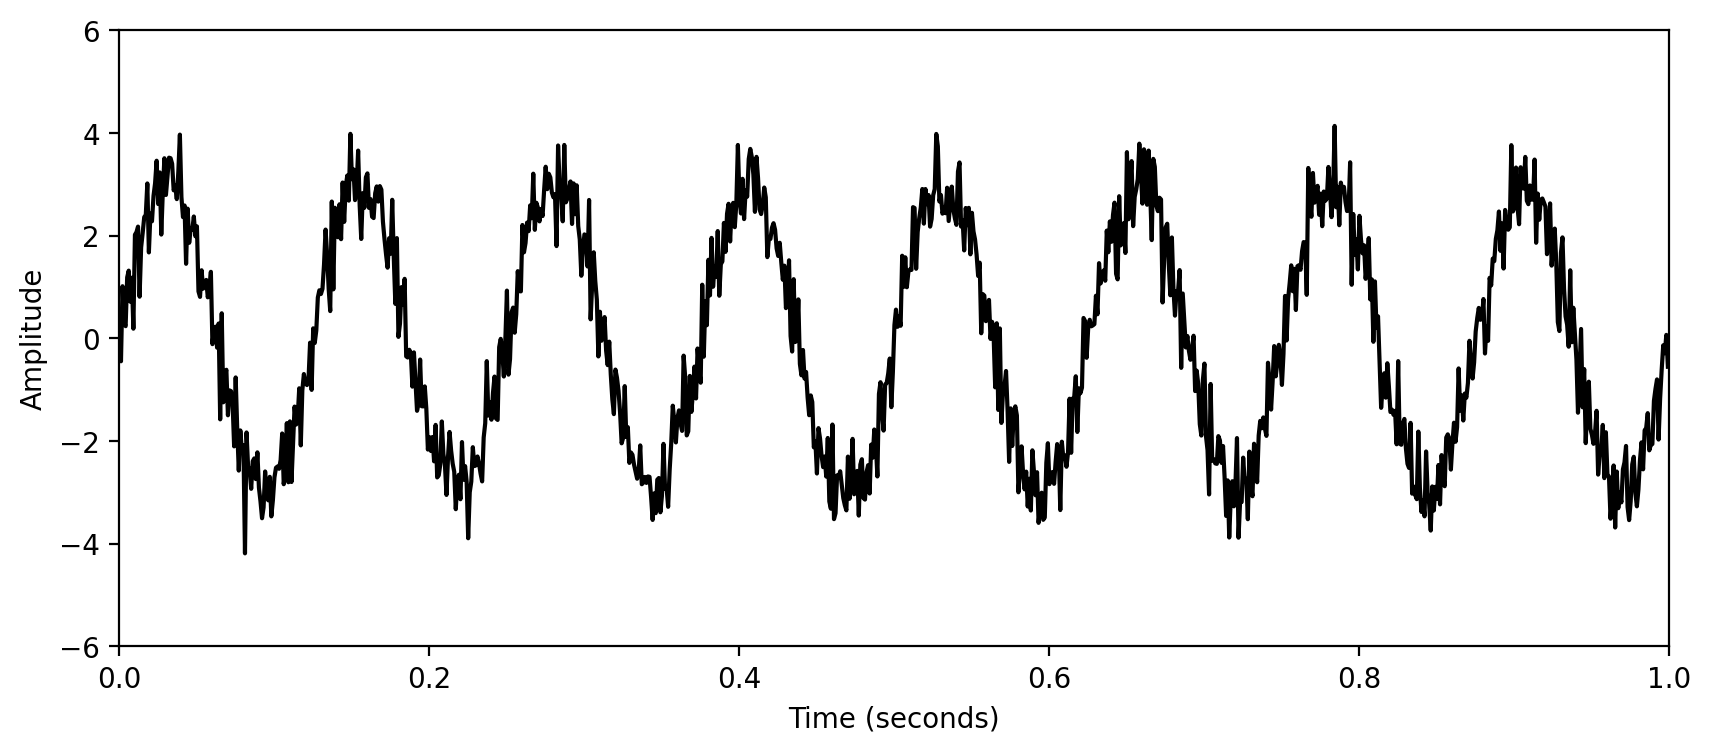

In [13]:
# @title

# @markdown Execute this cell to visualize the data

# @markdown The data is a sum of two sine waves with different frequencies and amplitudes, plus some noise

# Plot the signal
plt.figure(figsize=(10, 4))
plt.plot(t, signal, 'k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([0, 1])
plt.ylim([-6, 6])
plt.show()

## Interactive Demo 1: Signal parameters

Using an interactive widget, we can easily see how changing our slope estimate changes our model fit. We display the **residuals**, the differences between observed and predicted data, as line segments between the data point (observed response) and the corresponding predicted response on the model fit line.

- What value of $\hat{\theta}$ results in the lowest MSE?
- Is this a good way of estimating $\theta$?


In [ ]:
# @markdown Make sure you execute this cell to enable the widget!
@widgets.interact(theta_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0))
def plot_data_estimate(theta_hat):
  y_hat = theta_hat * x
  plot_observed_vs_predicted(x, y, y_hat, theta_hat)

Now we are going to introduce an artifact to our synthetic signal and see how it looks.

Artifacts can be seen as an overall increase in amplitude, the non-stationarity of a signal, a fixed power in a spurious frequency...

Artifact corrections:
    Detrending,
    Notch filter,
    Removing defective channels.

## Coding Exercise 1: Handling artifacts

In this exercise you will implement 

In [ ]:
def mse(x, y, theta_hat):
  """Compute the mean squared error

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta_hat (float): An estimate of the slope parameter

  Returns:
    float: The mean squared error of the data with the estimated parameter.
  """
  ####################################################
  ## TODO for students: compute the mean squared error
  # Fill out function and remove
  raise NotImplementedError("Student exercise: compute the mean squared error")
  ####################################################

  # Compute the estimated y
  y_hat = ...

  # Compute mean squared error
  mse = ...

  return mse


theta_hats = [0.75, 1.0, 1.5]
for theta_hat in theta_hats:
  print(f"theta_hat of {theta_hat} has an MSE of {mse(x, y, theta_hat):.2f}")

While visually exploring several estimates can be instructive, it's not the most efficient for finding the best estimate to fit our data. Another technique we can use is to choose a reasonable range of parameter values and compute the MSE at several values in that interval. This allows us to plot the error against the parameter value (this is also called an **error landscape**, especially when we deal with more than one parameter). We can select the final $\hat{\theta}$  ($\hat{\theta}_\textrm{MSE}$) as the one which results in the lowest error.

In [ ]:
# @markdown Execute this cell to loop over theta_hats, compute MSE, and plot results

# Loop over different thetas, compute MSE for each
theta_hat_grid = np.linspace(-2.0, 4.0)
errors = np.zeros(len(theta_hat_grid))
for i, theta_hat in enumerate(theta_hat_grid):
  errors[i] = mse(x, y, theta_hat)

# Find theta that results in lowest error
best_error = np.min(errors)
theta_hat = theta_hat_grid[np.argmin(errors)]


# Plot results
fig, ax = plt.subplots()
ax.plot(theta_hat_grid, errors, '-o', label='MSE', c='C1')
ax.axvline(theta, color='g', ls='--', label=r"$\theta_{True}$")
ax.axvline(theta_hat, color='r', ls='-', label=r"$\hat{{\theta}}_{MSE}$")
ax.set(
  title=fr"Best fit: $\hat{{\theta}}$ = {theta_hat:.2f}, MSE = {best_error:.2f}",
  xlabel=r"$\hat{{\theta}}$",
  ylabel='MSE')
ax.legend()
plt.show()

We can see that our best fit is $\hat{\theta}=1.18$ with an MSE of 1.45. This is quite close to the original true value $\theta=1.2$!


---
# Section 2: Transforming time series to the frequency domain

*Estimated timing to here from start of tutorial: 20 min*

While the approach detailed above (computing MSE at various values of $\hat\theta$) quickly got us to a good estimate, it still relied on evaluating the MSE value across a grid of hand-specified values. If we didn't pick a good range to begin with, or with enough granularity, we might miss the best possible estimator. Let's go one step further, and instead of finding the minimum MSE from a set of candidate estimates, let's solve for it analytically.

We can do this by minimizing the cost function. Mean squared error is a convex objective function, therefore we can compute its minimum using calculus. Please see video or Bonus Section 1 for this derivation! After computing the minimum, we find that:

\begin{equation}
\hat\theta = \frac{\mathbf{x}^\top \mathbf{y}}{\mathbf{x}^\top \mathbf{x}}
\end{equation}

where $\mathbf{x}$ and $\mathbf{y}$ are vectors of data points.

This is known as solving the normal equations. For different ways of obtaining the solution, see the notes on [Least Squares Optimization](https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf) by Eero Simoncelli.

## Coding Exercise 2: Implement the Fast Fourier Transform (FFT)

In this exercise, you will write a function that finds the optimal $\hat{\theta}$ value using the least squares optimization approach (the equation above) to solve MSE minimization. It should take arguments $x$ and $y$ and return the solution $\hat{\theta}$.

We will then use your function to compute $\hat{\theta}$ and plot the resulting prediction on top of the data.

In [ ]:
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """

  ################################################################################
  ## TODO for students: solve for the best parameter using least squares
  # Fill out function and remove
  raise NotImplementedError("Student exercise: solve for theta_hat using least squares")
  ################################################################################

  # Compute theta_hat analytically
  theta_hat = ...

  return theta_hat


theta_hat = solve_normal_eqn(x, y)
y_hat = theta_hat * x
plot_observed_vs_predicted(x, y, y_hat, theta_hat)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D2_ModelFitting/static/W1D2_Tutorial1_Solution_7a89ba24_0.png>



We see that the analytic solution produces an even better result than our grid search from before, producing $\hat{\theta} = 1.21$ with $\text{MSE} = 1.43$!

---
# Summary

*Estimated timing of tutorial: 30 minutes*

Linear least squares regression is an optimization procedure that can be used for data fitting:

  - Task: predict a value for $y_i$ given $x_i$
  - Performance measure: $\textrm{MSE}$
  - Procedure: minimize $\textrm{MSE}$ by solving the normal equations

**Key point**: We fit the model by defining an *objective function* and minimizing it.

**Note**: In this case, there is an *analytical* solution to the minimization problem and in practice, this solution can be computed using *linear algebra*. This is *extremely* powerful and forms the basis for much of numerical computation throughout the sciences.

---
# Notation

\begin{align}
x_{i} &\quad \text{input, independent variable}\\
y_{i} &\quad \text{measurement, dependent variable}\\
\mathbf{x} &\quad \text{vector of input values}\\
\mathbf{y} &\quad \text{vector of measurements}\\
\hat{y}_{i} &\quad \text{estimate of dependent variable}\\
\epsilon_{i} &\quad \text{measurement error}\\
\theta &\quad \text{slope parameter}\\
\hat{\theta} &\quad \text{estimated slope parameter}\\
\hat{\theta}_\text{MSE} &\quad \text{slope parameter estimated via the mean squared error}\\
\textrm{MSE} &\quad \text{mean squared error}\\
\end{align}

---
# Bonus

## Bonus Section 1: Least Squares Optimization Derivation

We will outline here the derivation of the least squares solution.

We first set the derivative of the error expression with respect to $\theta$ equal to zero,

\begin{align}
\frac{d}{d\theta}\frac{1}{N}\sum_{i=1}^N(y_i - \theta x_i)^2 &= 0 \\
\frac{1}{N}\sum_{i=1}^N-2x_i(y_i - \theta x_i) &= 0
\end{align}

where we used the chain rule. Now solving for $\theta$, we obtain an optimal value of:

\begin{equation}
\hat\theta = \frac{\sum_{i=1}^N x_i y_i}{\sum_{i=1}^N x_i^2}
\end{equation}

Which we can write in vector notation as:

\begin{equation}
\hat\theta = \frac{\mathbf{x}^\top \mathbf{y}}{\mathbf{x}^\top \mathbf{x}}
\end{equation}

<br>

This is known as solving the *normal equations*. For different ways of obtaining the solution, see the notes on [Least Squares Optimization](https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf) by Eero Simoncelli.